# Using dask distributed cluster to speed up computation of PV potential by factor of 10

In [22]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import time
from dask.distributed import Client
import core as core

import warnings
warnings.filterwarnings("ignore")


In [23]:
# location of era5 data on teachinghub
path="~/LEHRE/msc-intro-comp-met-ex-w2024/data/era5/"

Start dask cluster with 10 processes (workers), each with 5 threads. 

In [36]:
years = [2000]
months = range(6, 6+1)
files = []

files = [f"era5-{year}-{month:02}.nc" for year in years for month in months]

files_path = [path+f for f in files]

print(f"Load data for {years=} {months=}")
files_path

Load data for years=[2000] months=range(6, 7)


['~/LEHRE/msc-intro-comp-met-ex-w2024/data/era5/era5-2000-06.nc']

In [25]:
ds=xr.open_mfdataset( files_path, engine="h5netcdf", chunks={"valid_time":1e5} )

In [26]:
ds_eu = ds.sel(latitude=slice(70,35))
# ds_eu = ds_eu.sel(longitude=slice(0,30))
ds
# ds_eu = xr.concat([ds_eu.sel(longitude=slice(0, 35)), ds_eu.sel(longitude=slice(350, 359))], dim='longitude')

ds=xr.open_mfdataset(path+"era5-2000-*.nc", engine="h5netcdf", chunks={"valid_time":1e5} )
ds_1 = ds.sel(latitude=slice(70,35)).sel(longitude=slice(350,359.9))
ds_1['longitude'] = ds_1['longitude'] - 360
ds_eu

<xarray.Dataset> Size: 3GB
Dimensions:     (valid_time: 744, latitude: 141, longitude: 1440)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 6kB 2000-01-01 ... 2000-01-31T23:...
  * latitude    (latitude) float64 1kB 70.0 69.75 69.5 69.25 ... 35.5 35.25 35.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    expver      (valid_time) <U4 12kB dask.array<chunksize=(744,), meta=np.ndarray>
Data variables:
    t2m         (valid_time, latitude, longitude) float32 604MB dask.array<chunksize=(744, 41, 240), meta=np.ndarray>
    ssrd        (valid_time, latitude, longitude) float32 604MB dask.array<chunksize=(744, 41, 240), meta=np.ndarray>
    ssrdc       (valid_time, latitude, longitude) float32 604MB dask.array<chunksize=(744, 41, 240), meta=np.ndarray>
    u10         (valid_time, latitude, longitude) float32 604MB dask.array<chunksize=(744, 41, 240), meta=np.ndarray>
    v10         (valid_time, latitude, longitude) float32 604MB dask.array<chunksize=(744, 41, 240), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-21T19:50 GRIB to CDM+CF via cfgrib-0.9.1...

In [27]:
ds_eu["valid_time"]

<xarray.DataArray 'valid_time' (valid_time: 744)> Size: 6kB
array(['2000-01-01T00:00:00.000000000', '2000-01-01T01:00:00.000000000',
       '2000-01-01T02:00:00.000000000', ..., '2000-01-31T21:00:00.000000000',
       '2000-01-31T22:00:00.000000000', '2000-01-31T23:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 6kB 2000-01-01 ... 2000-01-31T23:...
    expver      (valid_time) <U4 12kB dask.array<chunksize=(744,), meta=np.ndarray>
Attributes:
    long_name:      time
    standard_name:  time

>  PV power potential and production. The PV power output at a site depends on
two factors: its PV power generation potential (PVpot) and the installed capacity.
As defined and used in this study, PVpot is a dimensionless magnitude accounting
for the performance of the PV cells with respect to their nominal power capacity
according to the actual ambient conditions. Therefore, PVpot multiplied by the
nominal installed watts of PV power capacity gives instantaneous PV power
production.
From:  “The impact of climate change on photovoltaic
power generation in Europe.” 

In [37]:
from dask.distributed import progress

from pathlib import Path
home = Path.home()
dask_workspace = home / "daskWorkspace"

# radiation J/m^2
# t2m temperature 2m in K

# Using Dask Client as a context manager
with Client(n_workers=20, threads_per_worker=4, local_directory=dask_workspace) as client:
    print(client)
    start_time = time.time()
    ds=xr.open_mfdataset( files_path, engine="h5netcdf", chunks={"valid_time":1e5} )
    # ds=xr.open_mfdataset(files_path, engine="netcdf4", chunks={"valid_time":1e5} )
    ds["wspd"] = core.windspeed(ds)

    ds_1 = ds.sel(latitude=slice(70,35)).sel(longitude=slice(350,359.9))
    ds_1['longitude'] = ds_1['longitude'] - 360

    ds_2 = ds.sel(latitude=slice(70,35)).sel(longitude=slice(0,30))

    ds_eu = xr.concat([ds_1, ds_2], dim="longitude")
    
    # ds_eu = xr.concat([ds_eu.sel(longitude=slice(0, 35)), ds_eu.sel(longitude=slice(350, 359))], dim='longitude')
    # pvpot = core.pv_pot(ds).groupby(ds.valid_time.dt.month).mean("valid_time").persist()
    # pvpot = core.pv_pot(ds_eu).groupby(ds_eu.valid_time.dt.month).mean("valid_time").compute()
    pvpot = core.pv_pot(ds_eu).compute()
    # progress(pvpot)
    # pvpot.compute()
    
    # pvpot = core.pv_pot(ds).mean("valid_time").compute()
    end_time = time.time()
    execution_time = end_time - start_time
print(f"Execution time: {execution_time:.5f} seconds")

<Client: 'tcp://127.0.0.1:46099' processes=20 threads=80, memory=753.83 GiB>
Execution time: 6.86074 seconds


In [38]:
second_month = 3600 * 24 * 30
standard_capacity = 237 # In watts per m^2
energy_month = pvpot * standard_capacity * second_month # Jules per month 1 panel would generate

NameError: name 'peak_capacity' is not defined

In [48]:
pvpot.min()

<xarray.DataArray ()> Size: 8B
array(0.)
Coordinates:
    number   int64 8B 0

In [7]:
ds_eu

<xarray.Dataset> Size: 405MB
Dimensions:     (valid_time: 744, latitude: 141, longitude: 161)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 6kB 2000-01-01 ... 2000-01-31T23:...
  * latitude    (latitude) float64 1kB 70.0 69.75 69.5 69.25 ... 35.5 35.25 35.0
  * longitude   (longitude) float64 1kB -10.0 -9.75 -9.5 ... 29.5 29.75 30.0
    expver      (valid_time) <U4 12kB dask.array<chunksize=(744,), meta=np.ndarray>
Data variables:
    t2m         (valid_time, latitude, longitude) float32 68MB dask.array<chunksize=(744, 41, 40), meta=np.ndarray>
    ssrd        (valid_time, latitude, longitude) float32 68MB dask.array<chunksize=(744, 41, 40), meta=np.ndarray>
    ssrdc       (valid_time, latitude, longitude) float32 68MB dask.array<chunksize=(744, 41, 40), meta=np.ndarray>
    u10         (valid_time, latitude, longitude) float32 68MB dask.array<chunksize=(744, 41, 40), meta=np.ndarray>
    v10         (valid_time, latitude, longitude) float32 68MB dask.array<chunksize=(744, 41, 40), meta=np.ndarray>
    wspd        (valid_time, latitude, longitude) float32 68MB dask.array<chunksize=(744, 41, 40), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-21T19:50 GRIB to CDM+CF via cfgrib-0.9.1...

In [47]:
print(f"{pvpot.shape}")
pvpot

(720, 141, 161)


<xarray.DataArray (valid_time: 720, latitude: 141, longitude: 161)> Size: 65MB
array([[[0.0115664 , 0.01190231, 0.01189722, ..., 0.01075943,
         0.00905249, 0.00721867],
        [0.01074876, 0.01110528, 0.01107951, ..., 0.00886567,
         0.00751669, 0.00657129],
        [0.01068728, 0.01129596, 0.01163023, ..., 0.00783311,
         0.00690155, 0.00597354],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.00687714, 0.00677144, 0.00691707, ..., 0.01378786,
         0.01148715, 0.00909211],
        [0.00524534, 0.00513986, 0.0052857 , ..., 0.0106908 ,
         0.00864295, 0.00710442],
        [0.0044365 , 0.00431064, 0.00439427, ..., 0.0098915 ,
         0.00837963, 0.00687192],
...
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.02729304, 0.02573461, 0.02494851, ..., 0.01812684,
         0.01710492, 0.01607026],
        [0.03063521, 0.02903737, 0.02826958, ..., 0.01707957,
         0.01610785, 0.01568309],
        [0.03948944, 0.03725677, 0.03519104, ..., 0.0167452 ,
         0.01633839, 0.01595137],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]]], dtype=float32)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 6kB 2000-06-01 ... 2000-06-30T23:...
  * latitude    (latitude) float64 1kB 70.0 69.75 69.5 69.25 ... 35.5 35.25 35.0
  * longitude   (longitude) float64 1kB -10.0 -9.75 -9.5 ... 29.5 29.75 30.0
    expver      (valid_time) <U4 12kB '0001' '0001' '0001' ... '0001' '0001'

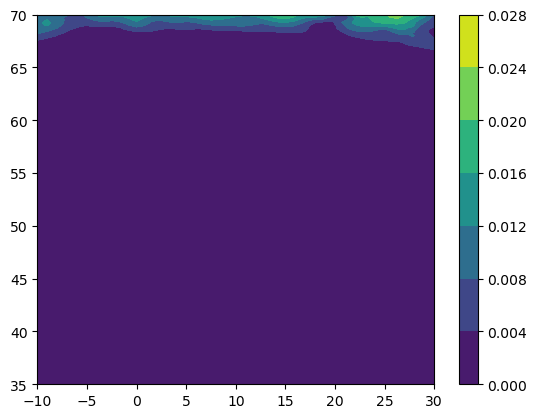

In [44]:
plt.contourf(ds_eu.longitude, ds_eu.latitude, pvpot[0])
plt.colorbar()

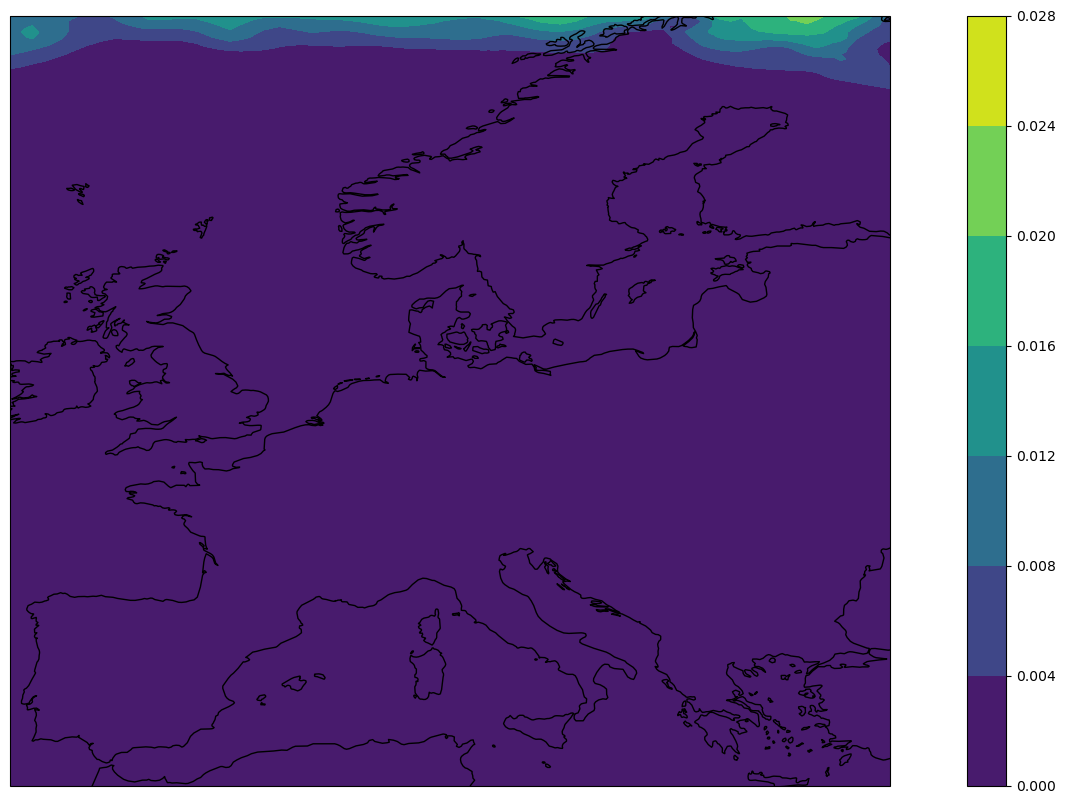

In [43]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# Create a figure with a specified projection
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Add coastlines and other features
ax.coastlines()
# ax.add_feature(cfeature.LAND)

# Create contour plot
contour = ax.contourf(ds_eu.longitude, ds_eu.latitude, pvpot[0])

cbar = plt.colorbar(contour, ax=ax, orientation='vertical', pad=0.05)

IndexError: index 12 is out of bounds for axis 0 with size 12

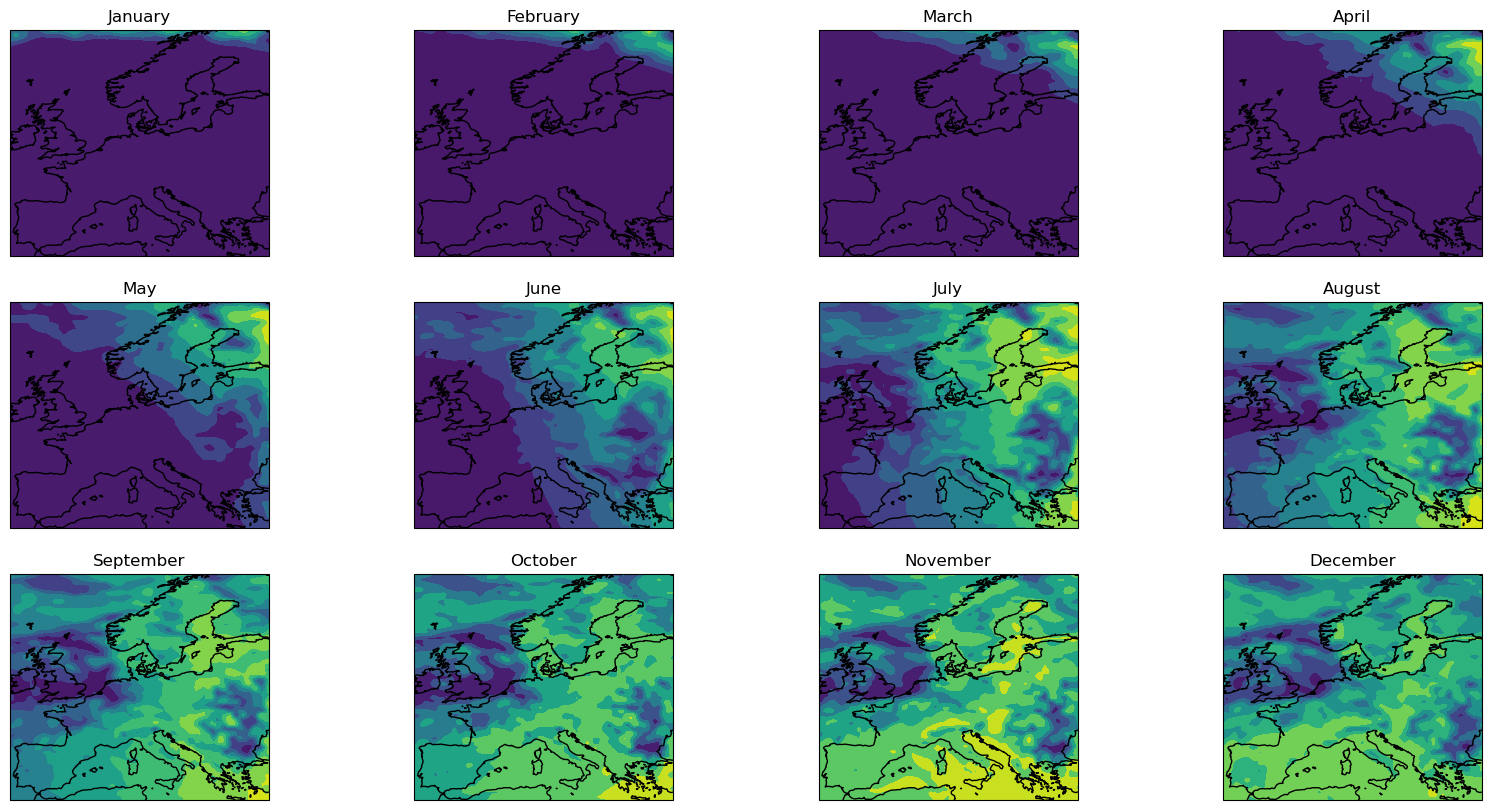

In [41]:
import calendar
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig, axs = plt.subplots(3, 4, figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})
# fig, axs = plt.subplots(figsize=(20, 10), nrows=3, ncols=4)
axs = axs.flatten()

for m in range(len(pvpot)):
    axs[m].add_feature(cfeature.COASTLINE)
    
    
    contour = axs[m].contourf(pvpot[m].longitude, pvpot[m].latitude, pvpot[m])
    axs[m].set_title(f"{calendar.month_name[m+1]}")

cbar = fig.colorbar(contour, ax=axs, orientation='horizontal', fraction=0.02, pad=0.1)


In [ ]:
# Climatological mean?
# Energy need changes per season, pv per month, maybe satisfy just january
# Enough energy potential to handle spikes? 

# Be clear with which energy need, start with year mean maybe then get more complex

We need to get the watt per time per area, watt per 

In [20]:
pvpot


<xarray.DataArray (latitude: 141, longitude: 161)> Size: 91kB
array([[0.00031222, 0.00031471, 0.00031644, ..., 0.00029615, 0.00029874,
        0.00029938],
       [0.00039874, 0.00040131, 0.00040305, ..., 0.00038027, 0.00038839,
        0.00037046],
       [0.00050565, 0.0005067 , 0.00050641, ..., 0.00046286, 0.0004429 ,
        0.00042279],
       ...,
       [0.12258013, 0.12240249, 0.12198541, ..., 0.12548393, 0.12480054,
        0.12452262],
       [0.12356924, 0.12347526, 0.1234018 , ..., 0.12480268, 0.12513228,
        0.12538747],
       [0.1241347 , 0.12420183, 0.12458853, ..., 0.12378363, 0.12454746,
        0.12511471]], dtype=float32)
Coordinates:
    number     int64 8B 0
  * latitude   (latitude) float64 1kB 70.0 69.75 69.5 69.25 ... 35.5 35.25 35.0
  * longitude  (longitude) float64 1kB -10.0 -9.75 -9.5 ... 29.5 29.75 30.0